In [1]:
from os.path import exists,basename
from json import load,dumps

In [2]:
from pytorch_transformers import BertTokenizer
from pytorch_transformers.modeling_bert import BertConfig, BertForSequenceClassification

In [3]:
import torch
import torch.nn as nn
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pathlib import Path
from sklearn.model_selection import train_test_split

In [4]:
import fastai
dir(fastai.text)

AttributeError: module 'fastai' has no attribute 'text'

In [6]:
#from fastai.text.transform import Tokenizer,BaseTokenizer,List,Vocab
from fastai.text.data import TextDataBunch
from fastai.text import *
from fastai.metrics import fbeta,accuracy

ImportError: cannot import name 'TextDataBunch' from 'fastai.text.data' (/home/roger/.local/share/virtualenvs/welfare_state_analytics-0GZ2Cxn6/lib/python3.7/site-packages/fastai/text/data.py)

In [5]:
from sklearn.metrics.classification import confusion_matrix
from sklearn.metrics import f1_score,fbeta_score

In [6]:
from confusion import get_confusion_plot, plot_confusion_matrix
from sklearn.metrics.classification import confusion_matrix
from random import random
from utils import Config, FastAiBertTokenizer, fill_categories, fill, accuracy, loss_batch_bert

In [73]:
pd.set_option('display.max_columns', 5)

In [8]:
data_file = '../data_swepub/E2.csv'

In [9]:
N_PER_CATEGORY=None
N_MAX=None
seed = 42 # use constant seed for predictability
seed = seed or int(10000 * random()) 

In [10]:
# load data
data = read_csv(data_file)

# randomize
data = data.sample(frac=1, random_state=seed)

# create 'text' column and put it first
data['text'] = data['title'] + " " + data['abstract'] 
data = data[data.columns.tolist()[:1] + data.columns.tolist()[-1:] + data.columns.tolist()[1:-1]]
data = data.fillna('')

text_col = 'text'
first_label_index=8 # <- be sure to use correct index
label_cols = list(data.columns[first_label_index:]) 

# filter data

# calculate sums
sums = DataFrame({ label: [ sum(data[label]) ] for label in label_cols })

train, val = train_test_split(data, train_size=0.6)
val, test = train_test_split(val, train_size=0.5)

# equalize categories?
if N_PER_CATEGORY:
    train = fill_categories(train, label_cols, n=N_PER_CATEGORY, random_state=seed+1)

if N_MAX:
    train = train.sample(n=N_MAX, random_state=seed+2)


In [11]:
sums

,101,102,103,104,105,106,107,201,202,203,204,205,206,207,208,209,210,211,301,302,303,304,305,401,402,403,404,405,501,502,503,504,505,506,507,508,509,601,602,603,604,605
0,6752,12867,20361,10622,10277,16201,232,6652,18109,11817,1782,5767,1171,2080,146,1244,1016,2008,9902,32851,13508,1099,991,2070,174,585,364,280,4892,11465,7602,4048,1315,2975,1480,3264,3325,1927,3506,2261,2107,808


In [12]:
orgs = set()
for org in data['organisation']:
    for o in org.split(';'):
        if o.endswith('.se'):
            orgs.add(o)

In [13]:
len(data), len(train), len(val), len(test)

(241903, 145141, 48381, 48381)

In [14]:
config = Config(
    testing=False,
    model_name="bert-large-cased",
    max_lr=3e-5,
    epochs=2,
    use_fp16=True,
    bs=64,
    discriminative=False,
    max_seq_len=256
)

In [15]:
bert_tok = BertTokenizer.from_pretrained(config.model_name)

In [16]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [17]:
fastai_tokenizer = Tokenizer(
                        tok_func=FastAiBertTokenizer(
                                    bert_tok, 
                                    max_seq_len=config.max_seq_len),
                        pre_rules=[],
                        post_rules=[])

In [18]:
# read the data into a databunch 
databunch = TextDataBunch.from_df(".", train, val, test,
    tokenizer=fastai_tokenizer, vocab=fastai_bert_vocab,
    include_bos=False,
    include_eos=False, 
    text_cols=text_col, 
    label_cols=label_cols, 
    bs=config.bs,
    collate_fn=partial(pad_collate, pad_first=False))

In [19]:
#from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.model_name, num_labels=len(label_cols))

In [20]:
loss_func = nn.BCEWithLogitsLoss()

In [21]:
# To change the loss_batch function in the loaded fastai module
module_basic_train = sys.modules['fastai.basic_train']
module_basic_train.loss_batch = loss_batch_bert
sys.modules['fastai.basic_train'] = module_basic_train

In [22]:
f1 = partial(fbeta, beta=1)

In [23]:
learner = Learner(
            databunch, bert_model,
            loss_func=loss_func,
            metrics=[ fbeta, f1, accuracy ]
            )

In [24]:
if config.use_fp16:
    learner = learner.to_fp16()

In [25]:
learner.callbacks.append(ShowGraph(learner))

In [26]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-04
Min loss divided by 10: 2.29E-03


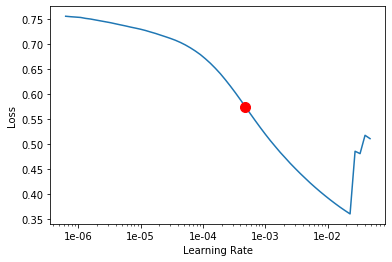

In [27]:
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,fbeta,fbeta,accuracy,time
0,0.038222,0.038255,0.738257,0.701733,0.690209,43:53
1,0.031692,0.034611,0.767964,0.728561,0.717926,44:45


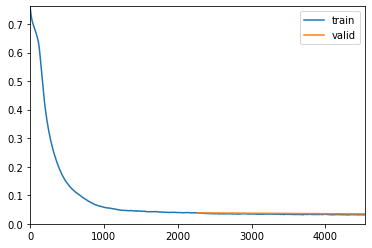

In [28]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr, moms=(0.8,0.7))

In [29]:
preds, y_true = learner.get_preds()

In [38]:
preds

tensor([[3.4699e-03, 9.8886e-04, 9.8315e-01,  ..., 3.9204e-04, 2.6324e-04,
         4.8977e-04],
        [1.1833e-03, 2.8338e-03, 4.1153e-02,  ..., 6.2878e-04, 3.2251e-04,
         3.0774e-04],
        [1.2066e-03, 7.2084e-04, 1.4779e-03,  ..., 3.9204e-04, 2.1824e-04,
         3.7410e-04],
        ...,
        [2.0269e-03, 1.2723e-02, 2.4155e-03,  ..., 6.9847e-03, 8.3973e-01,
         4.0465e-02],
        [1.5978e-03, 1.0945e-02, 2.1323e-03,  ..., 3.2351e-03, 8.2825e-01,
         3.1203e-02],
        [4.2813e-03, 1.5664e-02, 2.7469e-03,  ..., 5.0800e-03, 8.8100e-01,
         2.4054e-02]])

In [39]:
y_true

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [82]:
dataset = basename(data_file)
dataset = dataset[0:dataset.index('.')]
accuracy = (y_true.argmax(axis=1) == preds.argmax(axis=1)).float().mean()
f1 = f1_score(y_true.argmax(axis=1), preds.argmax(axis=1), average='weighted')
f2 = fbeta_score(y_true.argmax(axis=1), preds.argmax(axis=1), beta=2, average='weighted')
cm = confusion_matrix(y_true.argmax(axis=1), preds.argmax(axis=1))

(0.7052744779813276, 0.7125506576316437, tensor(0.7179))

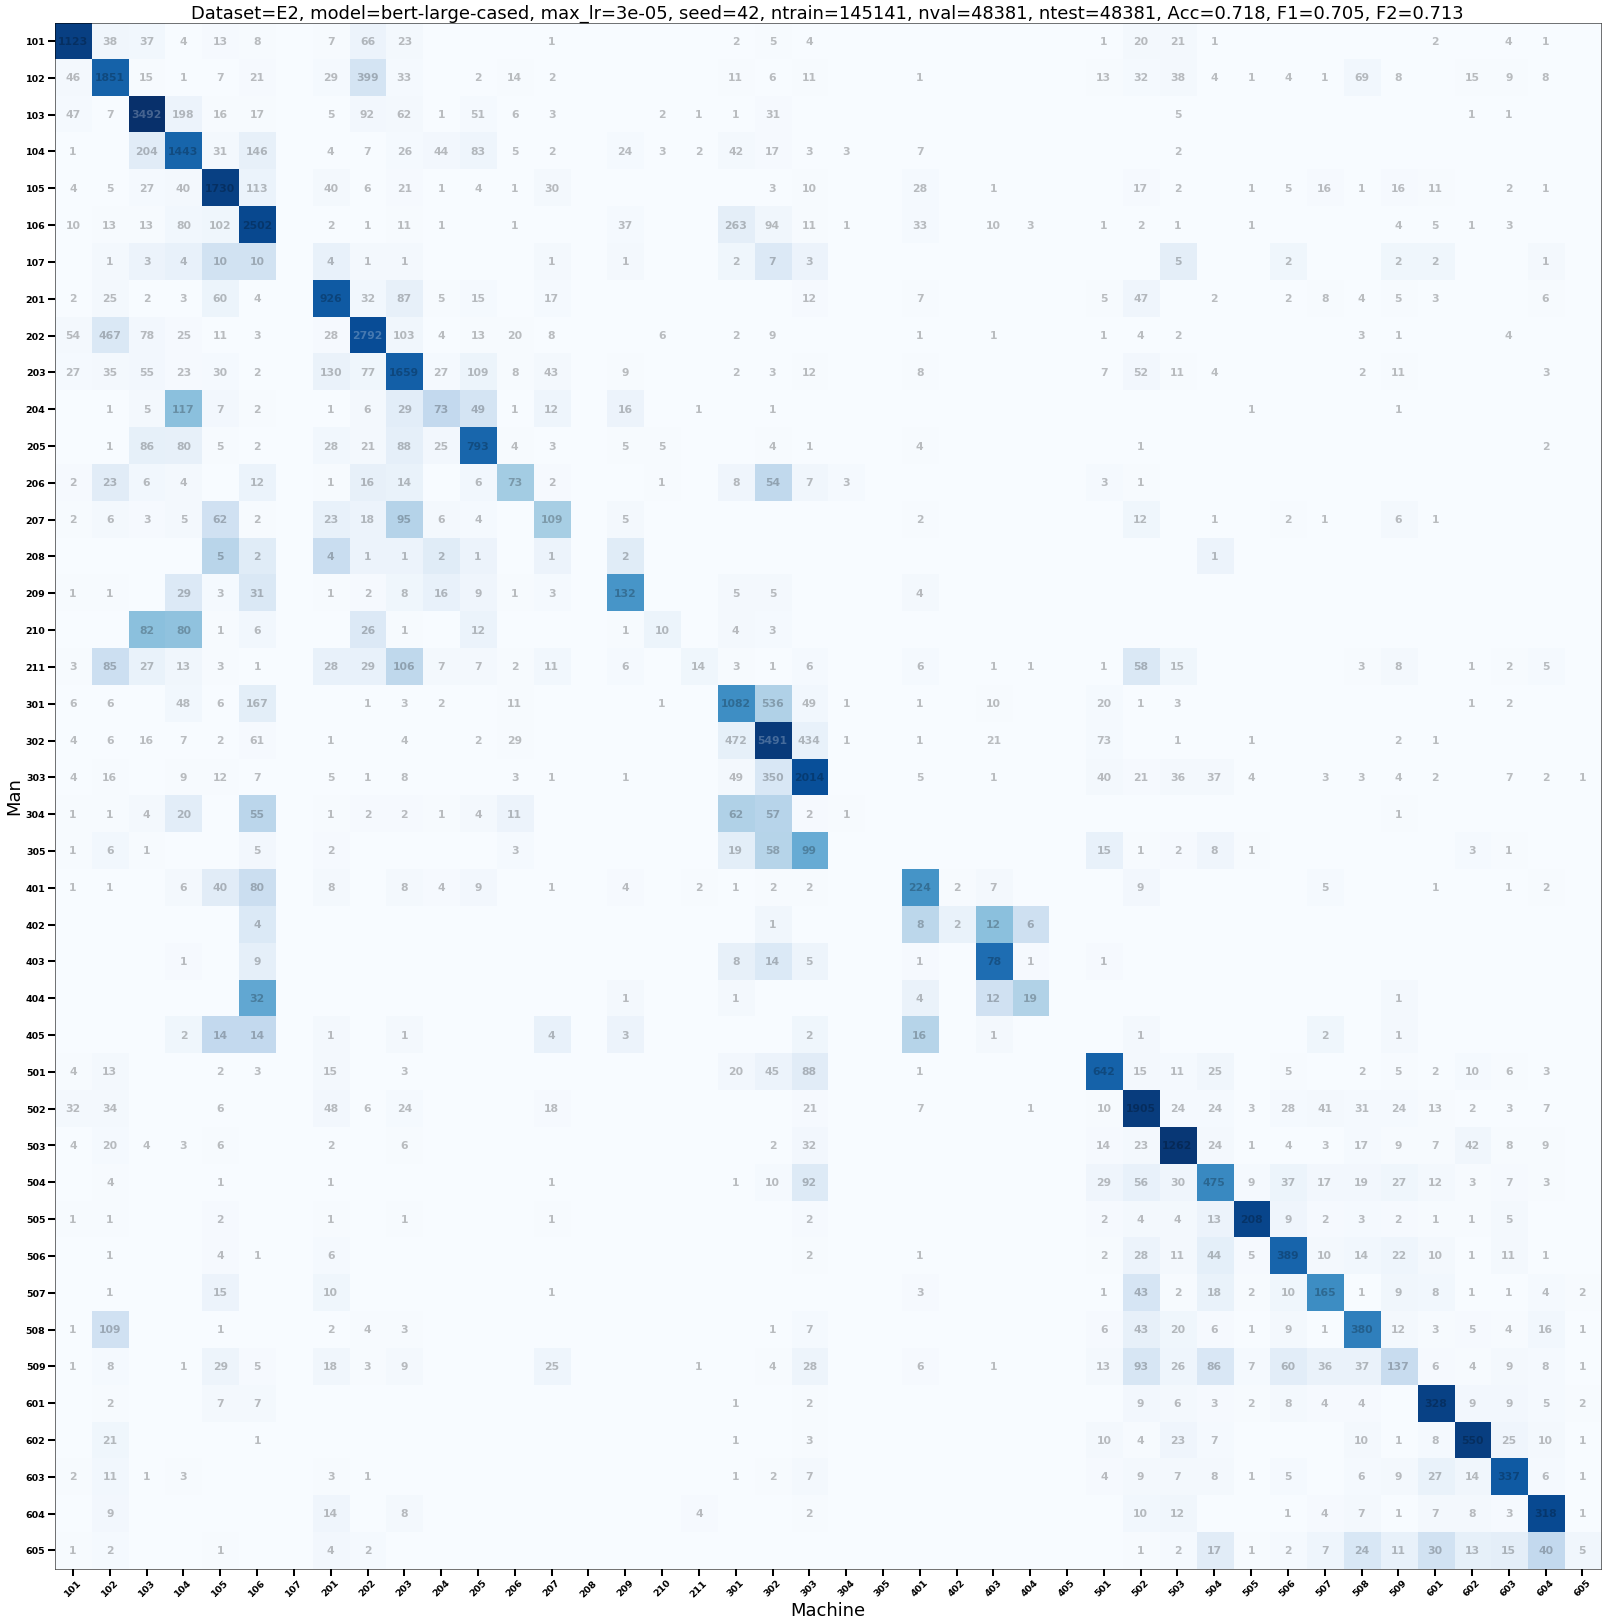

In [31]:
title=f'Dataset={dataset}, model={config.model_name}, max_lr={config.max_lr}, {("seed=" + str(seed) + ", ") if seed else ""}{("N per category=" + str(N_PER_CATEGORY) + ", ") if N_PER_CATEGORY else ""}ntrain={len(train)}, nval={len(val)}, ntest={len(test)}, Acc={accuracy:.3f}, F1={f1:.3f}, F2={f2:.3f}'
c = get_confusion_plot(cm=cm, normalize=False, labels=list(label_cols), title=title)

In [32]:
with open(f'results/result_{int(10000*random())}.txt', mode='w') as f:
    f.write(dumps(
        {
          'seed': seed,
          'dataset': basename(data_file),
          'train_size': len(train),
          'val_size': len(val),
          'test_size': len(val),
          'model': config.model_name,
          'max_lr': config.max_lr,
          'batch_size': config.bs,
          'max_seq_length': config.max_seq_len,
          'n_per_category': N_PER_CATEGORY,
          'n_max': N_MAX,
          'accuracy': float(accuracy),
          'f1': float(f1),
          'f2': float(f2),
          'labels': label_cols,
          'confusion': cm.tolist()
        }
    ))

In [79]:
DataFrame(preds[0:10].tolist(), columns=label_cols).style.background_gradient(axis=1, cmap='Blues')

,101,102,103,104,105,106,107,201,202,203,204,205,206,207,208,209,210,211,301,302,303,304,305,401,402,403,404,405,501,502,503,504,505,506,507,508,509,601,602,603,604,605
0,0.00346989,0.00098886,0.98315,0.00391482,0.00220839,0.00166139,0.000289103,0.000869367,0.00338978,0.00259098,0.000407653,0.00257087,0.000284622,0.00091819,0.000159679,0.000317509,0.00165492,0.00201116,0.000720838,0.00185306,0.000883046,0.000322507,0.000407653,0.000327584,9.91527e-05,0.000162193,0.000166038,0.000218242,0.000593021,0.00113357,0.000732181,0.000503336,0.000169975,0.000611834,0.000327584,0.000379984,0.000401335,0.000503336,0.000619042,0.000392042,0.000263238,0.000489766
1,0.00118328,0.00283385,0.0411529,0.701304,0.00486742,0.269422,0.00102022,0.000523376,0.00194182,0.00209927,0.00926801,0.00526085,0.00268344,0.000797833,0.000611834,0.00690384,0.0117778,0.00173421,0.00948571,0.00331152,0.000743703,0.00766587,0.000671928,0.00141036,0.000163465,0.000879606,0.000563675,0.000452976,0.000359769,0.000278031,0.000666702,0.000356971,0.000344643,0.000322507,0.000225168,0.00059071,0.000395115,0.000332741,0.000521336,0.000628784,0.000322507,0.000307743
2,0.00120659,0.000720838,0.00147794,0.00379483,0.0208045,0.0037801,0.000497474,0.00159785,0.000842642,0.00159785,0.000552779,0.000621463,0.000914614,0.00079163,0.000317509,0.00029137,0.000228713,0.000932636,0.0109024,0.0837404,0.85022,0.00146646,0.00997492,0.0014494,0.000257142,0.00109445,0.000278031,0.000422233,0.00218272,0.00144376,0.000465527,0.00357964,0.000375559,0.000511258,0.000503336,0.00041407,0.00247262,0.000322507,0.000339302,0.000392042,0.000218242,0.000374096
3,0.000298278,0.000588409,0.00156699,0.00251146,0.00079163,0.0201002,0.000228713,0.000319998,0.000444218,0.000372638,0.000310156,0.000300616,0.000872767,0.000150006,9.99303e-05,0.000465527,0.000194113,0.000259158,0.136954,0.831691,0.00588816,0.00703905,0.00241548,0.000280211,6.70922e-05,0.000698676,0.000192603,0.000106375,0.000447701,0.000310156,0.000340629,0.000423885,9.99303e-05,0.000192603,0.000178131,0.000218242,0.000259158,0.000159679,0.000284622,0.000219953,0.000197169,0.000157203
4,0.000452976,0.000788546,0.00232316,0.00131472,0.000947309,0.00423159,0.000218242,0.000493605,0.000557112,0.000602354,0.000348704,0.000315039,0.00153673,0.000201844,9.68561e-05,0.000337979,0.000154767,0.000420587,0.0178487,0.962883,0.00712143,0.00281186,0.00267301,0.000374096,6.01415e-05,0.000505305,0.000157203,0.000120536,0.000611834,0.000327584,0.000417316,0.000550625,8.95779e-05,0.000271592,0.000235972,0.000286854,0.000305349,0.000213188,0.00036259,0.000230507,0.000336662,0.000172652
5,0.00305151,0.0621031,0.00586534,0.00192673,0.000726488,0.00109019,0.000529542,0.00312365,0.849722,0.0256627,0.00163568,0.0064381,0.00457386,0.00227833,0.000179528,0.0003433,0.00307537,0.0109024,0.00117867,0.00100834,0.000865981,0.000572547,0.000312588,0.000345992,6.60521e-05,0.000109751,0.000180936,7.31125e-05,0.000704152,0.000797833,0.000382964,0.000312588,0.000293655,0.000293655,0.000198716,0.000973544,0.000559291,0.000317509,0.000422233,0.000368298,0.000563675,0.000352813
6,0.00200333,0.00273622,0.00189692,0.00217423,0.337859,0.00912564,0.00303965,0.0133766,0.00193426,0.00524045,0.00147794,0.00138852,0.000379984,0.0240994,0.00214059,0.00128431,0.000743703,0.00382448,0.000879606,0.000810387,0.00376541,0.000487857,0.00109873,0.0150726,0.000865981,0.00109445,0.00178916,0.00861077,0.00118328,0.0299297,0.0557203,0.0215741,0.0065135,0.0490396,0.155463,0.0047552,0.293101,0.00775554,0.0017822,0.00285601,0.00183151,0.00737437
7,0.00298103,0.00073792,0.978955,0.00796882,0.00198777,0.00157311,0.000267383,0.00070967,0.00271499,0.00254099,0.00056588,0.00429794,0.000255141,0.000785474,0.000152368,0.000317509,0.00201901,0.00174098,0.000664105,0.00162931,0.000656373,0.000300616,0.0003433,0.000317509,8.34963e-05,0.000162193,0.000145391,0.000188142,0.000561479,0.000893446,0.000729329,0.000472854,0.000166038,0.000515266,0.000298278,0.000293655,0.000351438,0.000461906,0.00063868,0.000378504,0

In [76]:
DataFrame(y_true[0:10].tolist(), columns=label_cols).style.background_gradient(axis=1, cmap='Blues')

,101,102,103,104,105,106,107,201,202,203,204,205,206,207,208,209,210,211,301,302,303,304,305,401,402,403,404,405,501,502,503,504,505,506,507,508,509,601,602,603,604,605
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
